In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [297]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

In [201]:
data = pd.read_csv('data/schedulingData/schedulingData.csv', index_col=0)
data.shape

(4331, 8)

In [202]:
data.head()

,Protocol,Compounds,InputFields,Iterations,NumPending,Hour,Day,Class
1,E,997.0,137.0,20.0,0.0,14.000000,Tue,F
2,E,97.0,103.0,20.0,0.0,13.816667,Tue,VF
3,E,101.0,75.0,10.0,0.0,13.850000,Thu,VF
4,E,93.0,76.0,20.0,0.0,10.100000,Fri,VF
5,E,100.0,82.0,20.0,0.0,10.366667,Fri,VF


In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4331 entries, 1 to 4331
Data columns (total 8 columns):
Protocol       4331 non-null object
Compounds      4331 non-null float64
InputFields    4331 non-null float64
Iterations     4331 non-null float64
NumPending     4331 non-null float64
Hour           4331 non-null float64
Day            4331 non-null object
Class          4331 non-null object
dtypes: float64(5), object(3)
memory usage: 304.5+ KB


In [204]:
data.describe()

,Compounds,InputFields,Iterations,NumPending,Hour
count,4331.000000,4331.000000,4331.000000,4331.000000,4331.000000
mean,497.742092,1537.055414,29.243593,53.389287,13.733760
std,1020.173220,3650.076483,34.417441,355.956566,3.981058
min,20.000000,10.000000,10.000000,0.000000,0.016667
25%,98.000000,134.000000,20.000000,0.000000,10.900000
50%,226.000000,426.000000,20.000000,0.000000,14.016667
75%,448.000000,991.000000,20.000000,0.000000,16.600000
max,14103.000000,56671.000000,200.000000,5605.000000,23.983333


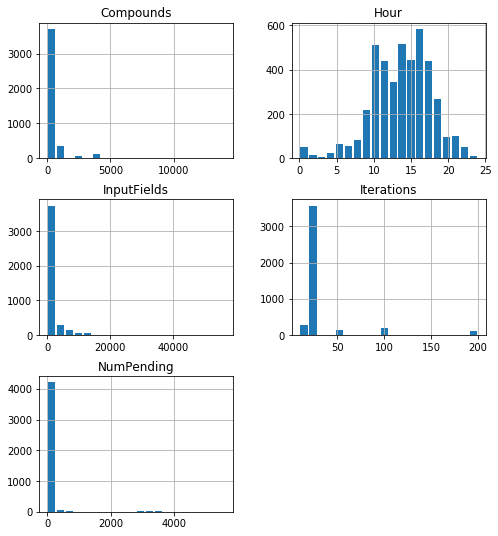

In [205]:
_ = data.hist(bins=20, rwidth=.8, figsize=(8, 9))

In [206]:
data.describe(include=['O'])

,Protocol,Day,Class
count,4331,4331,4331
unique,14,7,4
top,J,Fri,VF
freq,989,923,2211


In [207]:
# Execution time
# --------------
# very fast [< 1 m]
# fast [1-5 m]
# moderate [5-30 m]
# long [> 30 m]

data['Class'].value_counts()

VF    2211
F     1347
M      514
L      259
Name: Class, dtype: int64

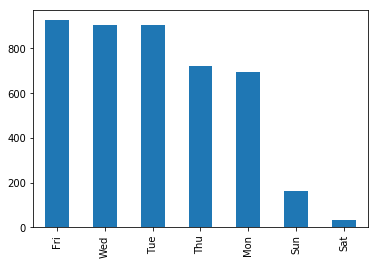

In [208]:
data['Day'].value_counts().plot.bar()

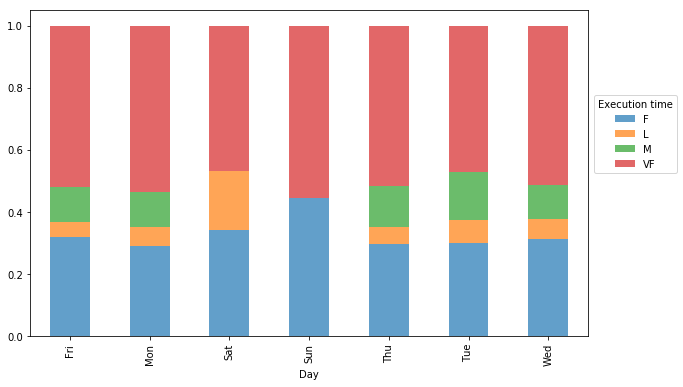

In [209]:
tmp = data.groupby(['Day', 'Class']).size().unstack().fillna(0)
tmp.div(tmp.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(10, 6), alpha=.7)
plt.legend(loc=[1.01, .5], title='Execution time')

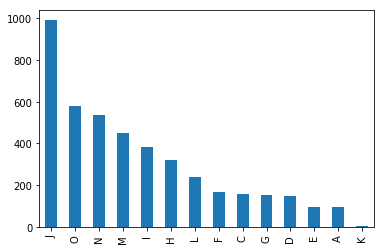

In [210]:
data['Protocol'].value_counts().plot.bar()

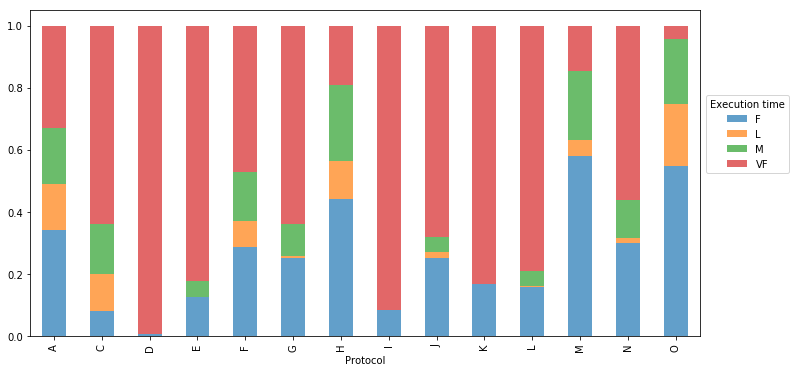

In [211]:
tmp = data.groupby(['Protocol', 'Class']).size().unstack()
tmp.div(tmp.sum(axis=1), axis=0).plot.bar(figsize=(12, 6), stacked=True, alpha=.7)
plt.legend(loc=[1.01, .5], title='Execution time')

In [212]:
def plot_dist(col_name, log_trans=False):
    g = data.groupby(['Class'])

    fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
    if not log_trans:
        g.apply(lambda x: x[col_name]).unstack(0).plot.kde(ax=ax[0])
        g.apply(lambda x: x[col_name]).unstack(0).plot.box(ax=ax[1])
    else:
        g.apply(lambda x: np.log1p(x[col_name])).unstack(0).plot.kde(ax=ax[0])
        g.apply(lambda x: np.log1p(x[col_name])).unstack(0).plot.box(ax=ax[1])

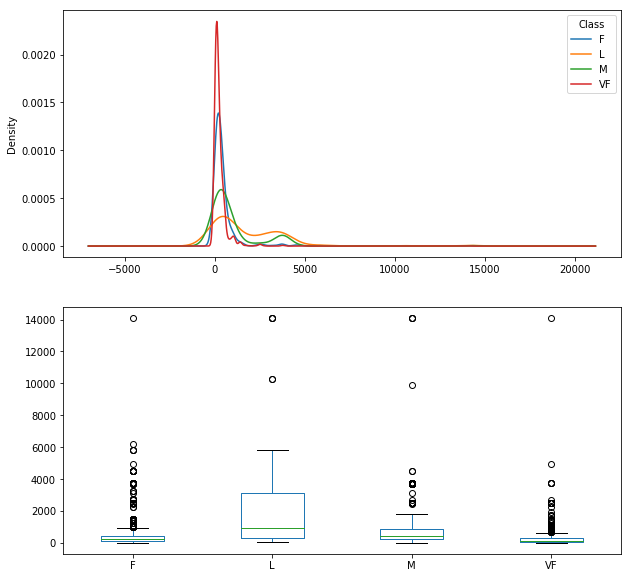

In [213]:
plot_dist('Compounds')

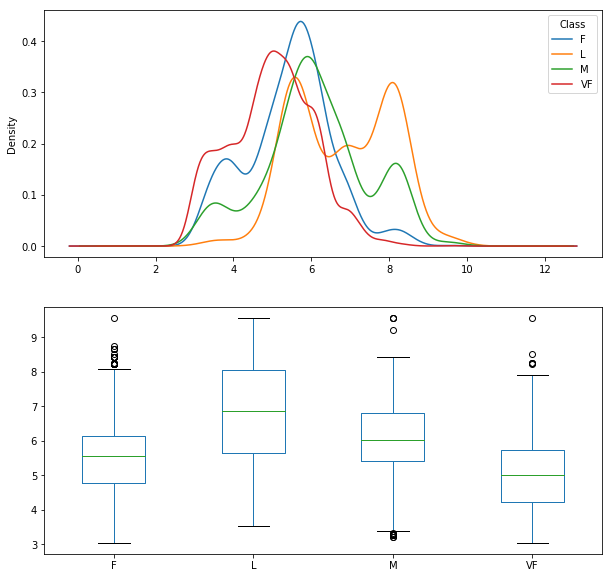

In [214]:
plot_dist('Compounds', log_trans=True)

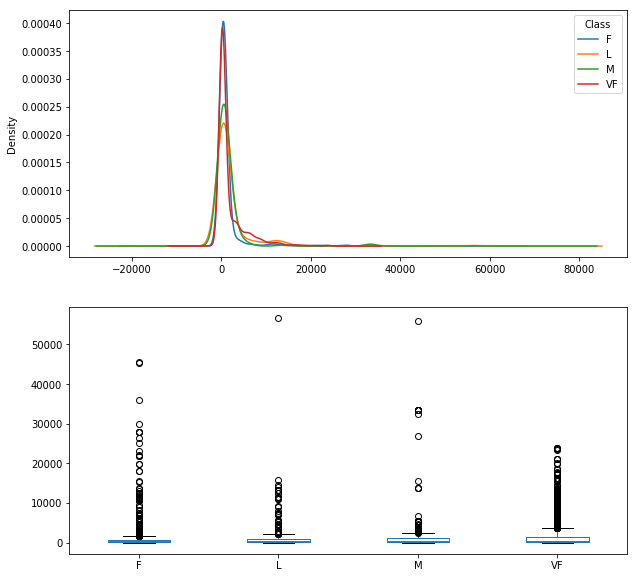

In [215]:
plot_dist('InputFields')

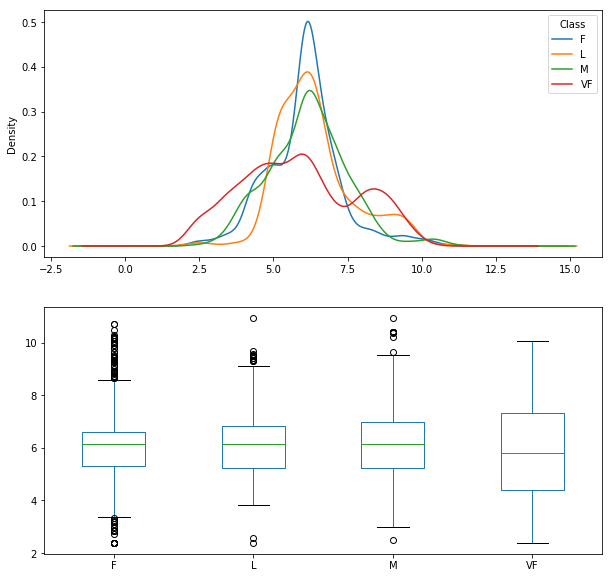

In [216]:
plot_dist('InputFields', log_trans=True)

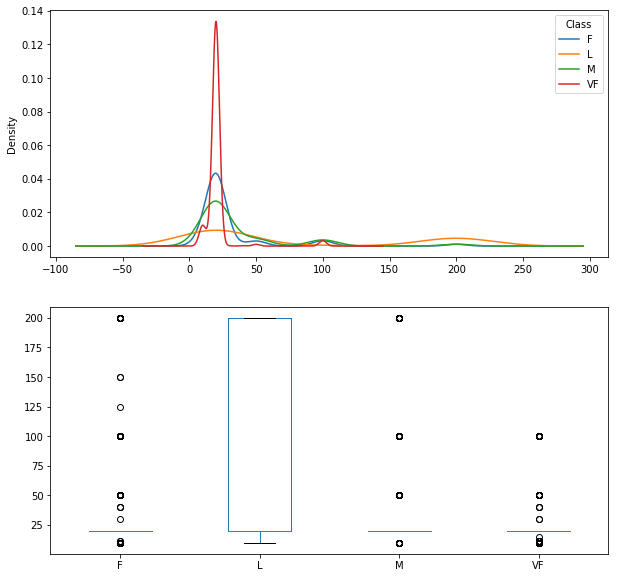

In [217]:
plot_dist('Iterations')

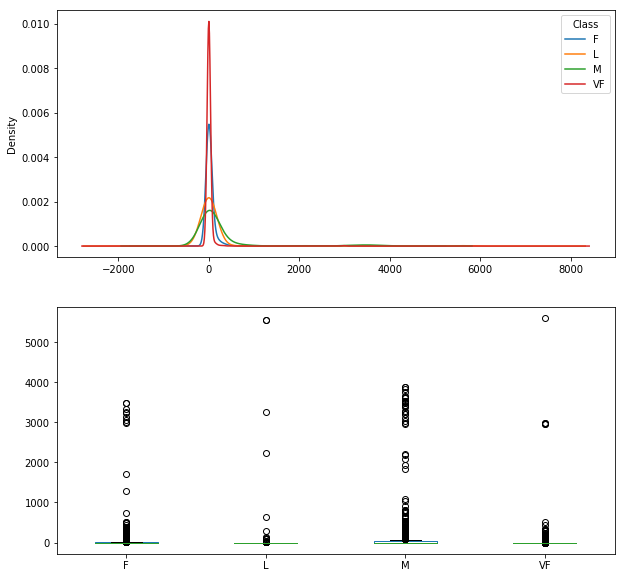

In [218]:
plot_dist('NumPending')

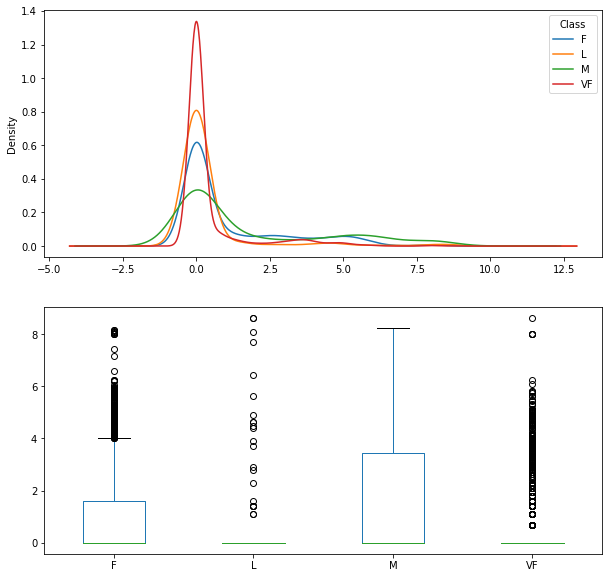

In [219]:
plot_dist('NumPending', log_trans=True)

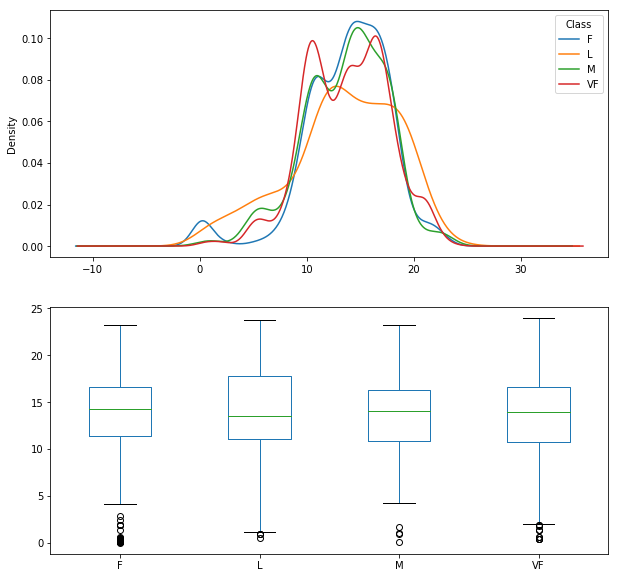

In [220]:
plot_dist('Hour')

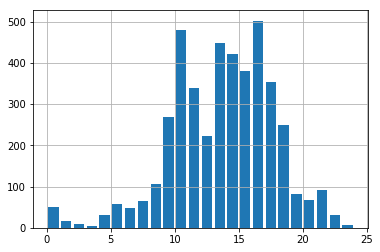

In [221]:
data['Hour'].hist(bins=24, rwidth=.8)

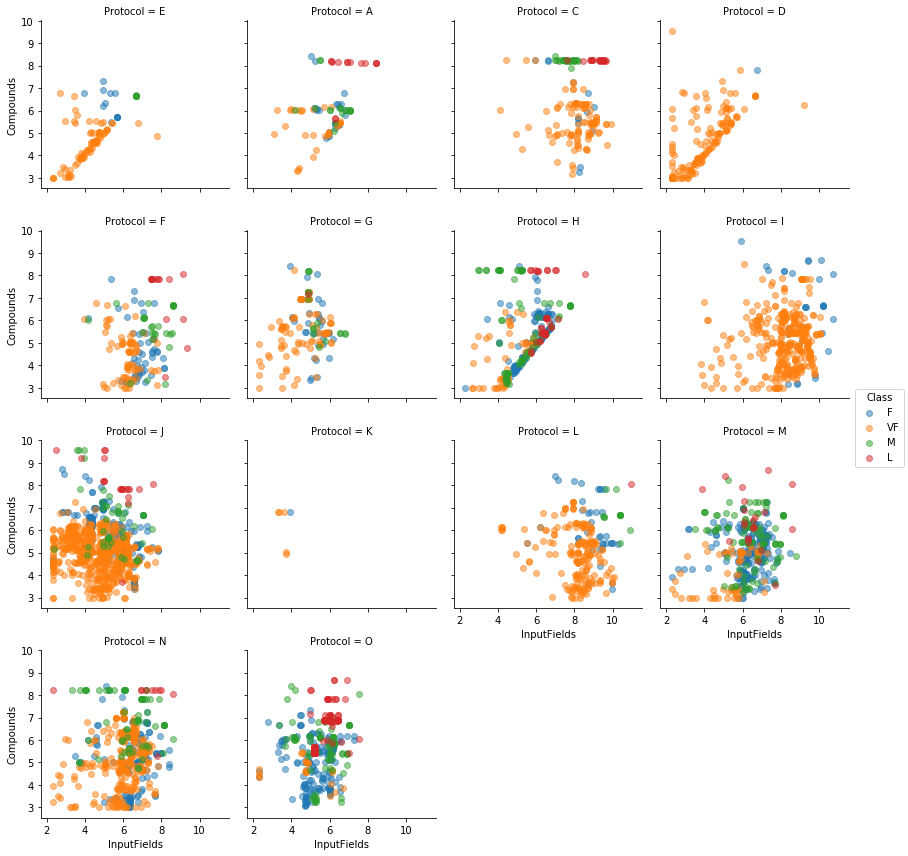

In [222]:
tmp = data.copy()
tmp['InputFields'] = np.log(tmp['InputFields'])
tmp['Compounds'] = np.log(tmp['Compounds'])
g = sns.FacetGrid(tmp, col='Protocol', hue='Class', col_wrap=4)
g.map(plt.scatter, 'InputFields', 'Compounds', alpha=.5).add_legend()

### Data Splitting 

In [223]:
data_dummy = pd.get_dummies(data, columns=['Protocol', 'Day'])

In [224]:
# log transform skewed data
for c in data_dummy.columns[data_dummy.dtypes==float][:-1]:
    data_dummy[c] = np.log1p(data_dummy[c])

In [225]:
class_map = {'VF':0, 'F':1, 'M':2, 'L':3}

In [226]:
re_class_map = {v:k for k,v in class_map.items()}

In [227]:
data['Class'] = data.Class.map(class_map)
data_dummy['Class'] = data_dummy.Class.map(class_map)

In [276]:
le = LabelEncoder()
for c in ['Day', 'Protocol']:
    data[c] = le.fit_transform(data[c])

In [277]:
data.shape, data_dummy.shape

((4331, 8), (4331, 27))

In [278]:
train, val = train_test_split(data, test_size=.2, stratify=data['Class'], random_state=123)
train_dummy, val_dummy = train_test_split(data_dummy, test_size=.2, stratify=data['Class'], random_state=123)

In [230]:
train.shape, val.shape

((3464, 8), (867, 8))

In [231]:
train['Class'].value_counts() / len(train)

0    0.510681
1    0.310912
2    0.118649
3    0.059758
Name: Class, dtype: float64

In [232]:
train_dummy['Class'].value_counts() / len(train_dummy)

0    0.510681
1    0.310912
2    0.118649
3    0.059758
Name: Class, dtype: float64

In [233]:
val['Class'].value_counts() / len(val)

0    0.509804
1    0.311419
2    0.118800
3    0.059977
Name: Class, dtype: float64

In [234]:
val_dummy['Class'].value_counts() / len(val_dummy)

0    0.509804
1    0.311419
2    0.118800
3    0.059977
Name: Class, dtype: float64

In [281]:
X_train = train.drop('Class', axis=1)
y_train = train['Class']

X_train_dummy = train_dummy.drop('Class', axis=1)
y_train_dummy = train_dummy['Class']

X_train.shape, y_train.shape, X_train_dummy.shape, y_train_dummy.shape

((3464, 7), (3464,), (3464, 26), (3464,))

In [282]:
X_val = val.drop('Class', axis=1)
y_val = val['Class']

X_val_dummy = val_dummy.drop('Class', axis=1)
y_val_dummy = val_dummy['Class']

X_val.shape, y_val.shape, X_val_dummy.shape, y_val_dummy.shape

((867, 7), (867,), (867, 26), (867,))

### 5 repeated 10 folds cross-validation

In [237]:
cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=123)

### customized cost function

In [238]:
cost_mat = np.array([[0, 1, 5, 10],
                     [1, 0, 5, 5],
                     [1, 1, 0, 1],
                     [1, 1, 1, 0]])
cost_mat = cost_mat.T

def JobCost(y_true, y_pred):
    con_mat = confusion_matrix(y_true, y_pred)
    return np.dot(con_mat.ravel(), cost_mat.ravel())/len(y_true)

cost_scorer = make_scorer(JobCost, greater_is_better=False)
kappa_scorer = make_scorer(cohen_kappa_score)
accuracy_scorer = make_scorer(accuracy_score)

In [239]:
# multi metrics
scoring = {
    'cost':cost_scorer, 
    'accuracy':accuracy_scorer,
    'kappa':kappa_scorer,
}

### LogisticRegression

In [291]:
lr_params = {'C': np.exp2(np.arange(-2, 10)), 'penalty':['l1', 'l2']}

In [292]:
lr_grid = GridSearchCV(LogisticRegression(), lr_params, cv=cv, scoring=cost_scorer, verbose=1, refit=True)

In [293]:
lr_grid.fit(X_train_dummy, y_train_dummy)

Fitting 50 folds for each of 24 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 17.9min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd99d81cdd8>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  2.50000e-01,   5.00000e-01,   1.00000e+00,   2.00000e+00,
         4.00000e+00,   8.00000e+00,   1.60000e+01,   3.20000e+01,
         6.40000e+01,   1.28000e+02,   2.56000e+02,   5.12000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(JobCost, greater_is_better=False), verbose=1)

In [294]:
lr_grid.best_score_, lr_grid.best_params_

(-0.69919168591224024, {'C': 512.0, 'penalty': 'l1'})

### SVC

In [298]:
lsvc = GridSearchCV(make_pipeline(StandardScaler(), SVC(class_weight='balanced')), 
                    {'svc__C':np.exp2(np.arange(-2, 11, 2))}, cv=cv, scoring=cost_scorer, verbose=1, refit=True)

In [299]:
lsvc.fit(X_train_dummy, y_train_dummy)

Fitting 50 folds for each of 7 candidates, totalling 350 fits


[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:  7.6min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd99d81cdd8>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svc__C': array([  2.50000e-01,   1.00000e+00,   4.00000e+00,   1.60000e+01,
         6.40000e+01,   2.56000e+02,   1.02400e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(JobCost, greater_is_better=False), verbose=1)

In [300]:
lsvc.best_score_, lsvc.best_params_

(-0.35629330254041569, {'svc__C': 64.0})

In [267]:
lsvc.best_score_, lsvc.best_params_

(-0.35860277136258661, {'C': 16.0})

In [268]:
JobCost(y_val_dummy, lsvc.predict(X_val_dummy))

0.37024221453287198

In [269]:
cohen_kappa_score(y_val_dummy, lsvc.predict(X_val_dummy))

0.66431835972022324

In [270]:
accuracy_score(y_val_dummy, lsvc.predict(X_val_dummy))

0.78777393310265287

In [301]:
confusion_matrix(y_val_dummy, lsvc.predict(X_val_dummy))

array([[380,  54,   8,   0],
       [ 36, 199,  31,   4],
       [  8,  22,  67,   6],
       [  2,   1,   4,  45]])

### DecisionTreeClassifier

In [285]:
tree_grid = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), 
                         {'max_depth': [None, 3, 5, 7, 9], 'min_samples_split':[2, 5, 10, 20]}, 
                         cv=cv, scoring=cost_scorer, verbose=1)

In [286]:
tree_grid.fit(X_train, y_train)

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   17.9s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd99d81cdd8>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 10, 20], 'max_depth': [None, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(JobCost, greater_is_better=False), verbose=1)

In [287]:
tree_grid.best_score_, tree_grid.best_params_

(-0.4020785219399538, {'max_depth': None, 'min_samples_split': 10})

### RandomForestClassifier

In [289]:
rf_params = {
    'n_estimators': [100,], 
     'max_depth':[None, 3, 5, 7, 9], 
     'min_samples_split': [2, 5, 10, 20]
}

rf_grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), 
                       rf_params, cv=cv, scoring=cost_scorer, verbose=1)

In [290]:
rf_grid.fit(X_train, y_train)

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  7.1min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd99d81cdd8>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 10, 20], 'max_depth': [None, 3, 5, 7, 9], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(JobCost, greater_is_better=False), verbose=1)

In [295]:
rf_grid.best_score_, rf_grid.best_params_

(-0.33591224018475752,
 {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100})

In [304]:
confusion_matrix(y_val, rf_grid.predict(X_val)).T

array([[403,  39,   7,   1],
       [ 32, 208,  30,   4],
       [  4,  19,  61,   3],
       [  3,   4,   5,  44]])